In [14]:
from __future__ import unicode_literals

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager
import seaborn as sns

import fnmatch
import glob
import dropbox

!ln -s /Users/matthiashugli/Virtualenvs/youth-base/youth-base/config.py config.py
from config import dbx_token
dbx = dropbox.Dropbox(dbx_token)

ln: config.py: File exists


In [28]:
sns.set(font='Meiryo', style='white')

In [4]:
path = '/Users/matthiashugli/Dropbox/bucket/super-league-stats/*'
path2 = '/Users/matthiashugli/Dropbox/bucket/super-league-stats/raw_baumann_fbref_saison20-21.csv'

df = pd.DataFrame()
for filename in glob.glob(path):
    #print(filename)
    file = pd.read_csv(filename, header=0, delimiter=',', low_memory=False)
    file.insert(0, 'filename', filename)
    df = df.append(file)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df[['source', 'file']] = df.filename.apply(lambda x: pd.Series(str(x).split('raw_')))
df[['goalkeeper', 'split6']] = df.file.apply(lambda x: pd.Series(str(x).split('_fbref')))
df['goalkeeper'] = df.goalkeeper.map(lambda x: x[0].upper() + x[1:])
df = df.drop(columns=['filename', 'source', 'file', 'split6'])
df = df.dropna(how='all')
df.goalkeeper = df.goalkeeper.astype('category')

In [7]:
# Exception Von Ballmoos
df['goalkeeper'] = df.goalkeeper.apply(lambda x: 'Von Ballmoos' if fnmatch.fnmatch(x, 'Vonballmoos') else x)

In [8]:
df['shots_faced'] = df.saves + df.ga
super_league_stats = df[df.comp == 'Super League']

In [9]:
print(super_league_stats.info())
print(super_league_stats.count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 36
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          341 non-null    object  
 1   day           341 non-null    object  
 2   comp          341 non-null    object  
 3   round         341 non-null    object  
 4   venue         341 non-null    object  
 5   result        341 non-null    object  
 6   squad         341 non-null    object  
 7   opponent      341 non-null    object  
 8   start         341 non-null    object  
 9   pos           341 non-null    object  
 10  min           341 non-null    float64 
 11  sota          341 non-null    float64 
 12  ga            341 non-null    float64 
 13  saves         341 non-null    float64 
 14  save%         330 non-null    float64 
 15  cs            341 non-null    float64 
 16  pkatt         341 non-null    float64 
 17  pka           341 non-null    float64 
 18  pksv       

In [10]:
#shots_saves = df.groupby('goalkeeper')['sota', 'saves', 'ga'].sum().reset_index()
#shots_saves = df.groupby('goalkeeper').agg({'sota': ['sum', 'mean'], 'saves': ['sum'], 'ga': ['sum']}).reset_index()
shots_saves = super_league_stats.groupby('goalkeeper').agg(shots_faced=('shots_faced', 'sum'), shots_faced_mean=('shots_faced', 'mean'), saves=('saves', 'sum'), goals=('ga', 'sum')).reset_index()
shots_saves['save_perc'] = shots_saves.saves / shots_saves.shots_faced * 100

In [11]:
print(shots_saves)

      goalkeeper  shots_faced  shots_faced_mean  saves  goals  save_perc
0        Baumann        120.0          4.444444   91.0   29.0  75.833333
1        Brecher        167.0          4.638889  110.0   57.0  65.868263
2        Büchel        151.0          4.314286   96.0   55.0  63.576159
3           Diaw        155.0          4.558824  105.0   50.0  67.741935
4         Fayulu         82.0          5.466667   58.0   24.0  70.731707
5   Fickentscher        111.0          5.285714   76.0   35.0  68.468468
6          Frick        152.0          4.606061  100.0   52.0  65.789474
7        Lindner        143.0          4.612903   97.0   46.0  67.832168
8        Müller        145.0          4.264706   90.0   55.0  62.068966
9         Osigwe         47.0          5.222222   34.0   13.0  72.340426
10  Von Ballmoos         90.0          2.903226   68.0   22.0  75.555556
11          Zigi        147.0          4.200000  100.0   47.0  68.027211


In [12]:
team_colors = ['black', 'white', 'red', 'white', 'white', 'white', 'red', 'blue', 'blue', 'black', 'yellow', 'green']
outline_colors = ['black', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'black', 'black', 'green']

label_xpos = [0.08, -0.05, -0.05, -0.3, -0.05, -0.05, -0.3, 0.05, -0.05, -0.05, -0.05, -0.05]
label_ypos = [0.05, 0.5, 0.5, -0.6, 0.5, 0.5, -0.6, 0.2, 0.5, 0.5, 0.5, 0.5]
goalkeeper = shots_saves.goalkeeper.tolist()
color_dict = dict(zip(goalkeeper, team_colors))

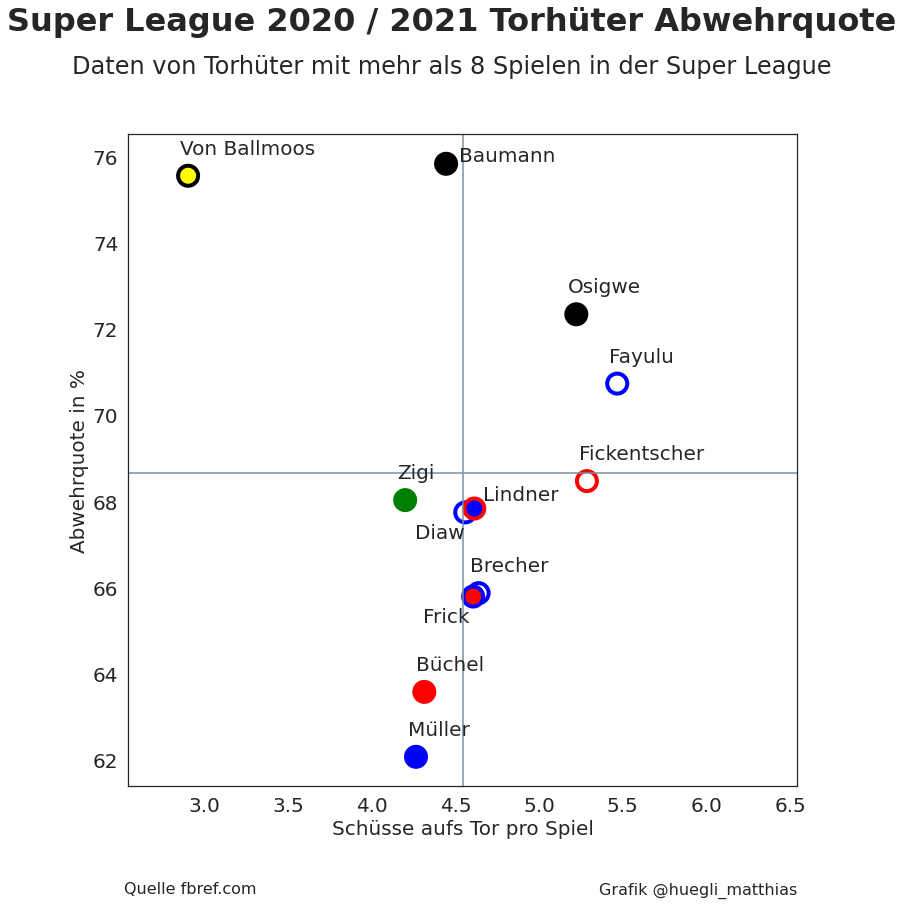

In [29]:
fig = plt.figure(figsize=[12,12])
kwargs = {'palette': team_colors, 'edgecolor': outline_colors, 'linewidth': 4}

graph = sns.scatterplot(x='shots_faced_mean', y='save_perc', s=400, data=shots_saves, legend=False, hue='goalkeeper', **kwargs)

for i in range(shots_saves.shape[0]):
    plt.text(x=shots_saves.shots_faced_mean[i]+label_xpos[i], 
        y=shots_saves.save_perc[i]+label_ypos[i], 
        s=shots_saves.goalkeeper[i], 
        fontsize=20,
        bbox=dict(facecolor='gray', alpha=0))

#sns.despine()
graph.axhline(shots_saves.save_perc.mean(), color='#78909C')
graph.axvline(shots_saves.shots_faced_mean.mean(), color='#78909C')

plt.xlim(shots_saves.shots_faced_mean.mean()-2, shots_saves.shots_faced_mean.mean()+2)

#plt.title('Super League 2020 / 2021 Torhüter Abwehrquote \n Nur Daten von Torhüter mit 9 Spielen oder mehr, Quelle fbref.com', fontsize=24)
plt.xlabel('Schüsse aufs Tor pro Spiel', fontsize=20)
plt.ylabel('Abwehrquote in %', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.text(0.5, 1, 'Super League 2020 / 2021 Torhüter Abwehrquote', ha='center', fontsize=32, fontweight='bold')
fig.text(0.5, 0.95, 'Daten von Torhüter mit mehr als 8 Spielen in der Super League', ha='center', fontsize=24)
fig.text(0.12, 0.001, 'Quelle fbref.com', ha='left', fontsize=16)
fig.text(0.9, 0.001, 'Grafik @huegli_matthias', ha='right', fontsize=16)

plt.savefig('SuperLeague20_21_GK_SavePercentage.png')
plt.show()
